In [157]:
import pickle
import pandas as pd
import os
from explainers.dce import DistributionalCounterfactualExplainer
import torch
from utils.visualization import *
from utils.data_processing import *
import numpy as np
import matplotlib.pyplot as plt


pd.set_option('display.max_columns', None)

%reload_ext autoreload
%autoreload 2

In [158]:
data_path = 'data/hotel_booking'

In [159]:
df_ = pd.read_csv('data/hotel_booking/hotel_bookings.csv')
df = df_.copy()

In [145]:
df, label_mappings = feature_encoding(df=df, target_name='is_canceled', target_encode_dict={})

In [146]:
factual = pd.read_csv(os.path.join(data_path,'factual.csv'))
counterfactual = pd.read_csv(os.path.join(data_path,'counterfactual.csv'))

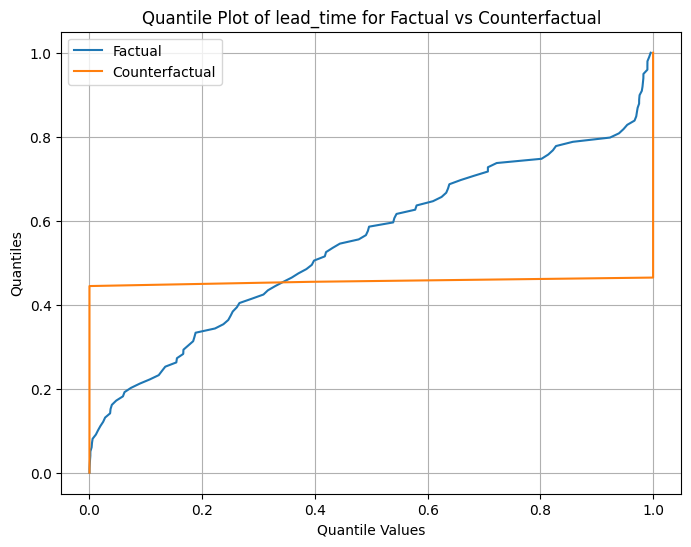

In [147]:
plot_quantile(factual=factual, counterfactual=counterfactual, column_name='is_canceled')

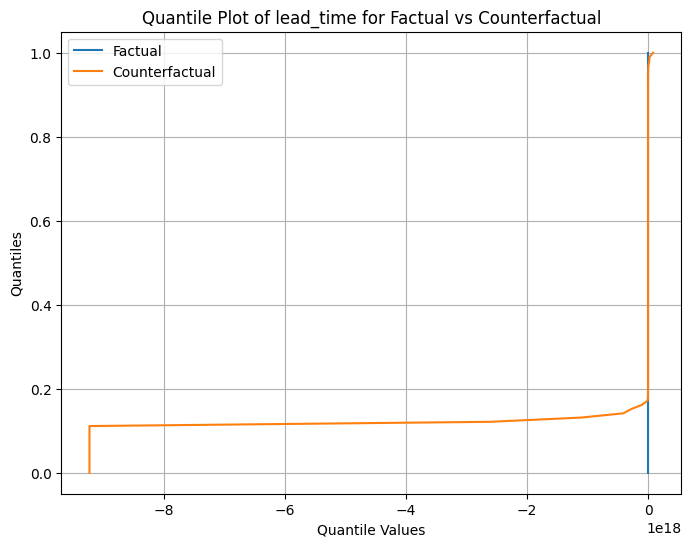

In [148]:
plot_quantile(factual=factual, counterfactual=counterfactual, column_name='stays_in_weekend_nights')

In [151]:
factual['is_canceled'].mean()

0.45301930738064

In [152]:
counterfactual['is_canceled'].mean()

0.543924027

In [155]:
with open(os.path.join(data_path, 'explainer.pkl'), 'rb') as file:
    explainer = pickle.load(file)

DEBUG:matplotlib.colorbar:locator: <matplotlib.ticker.AutoLocator object at 0x0000020B5D42E520>


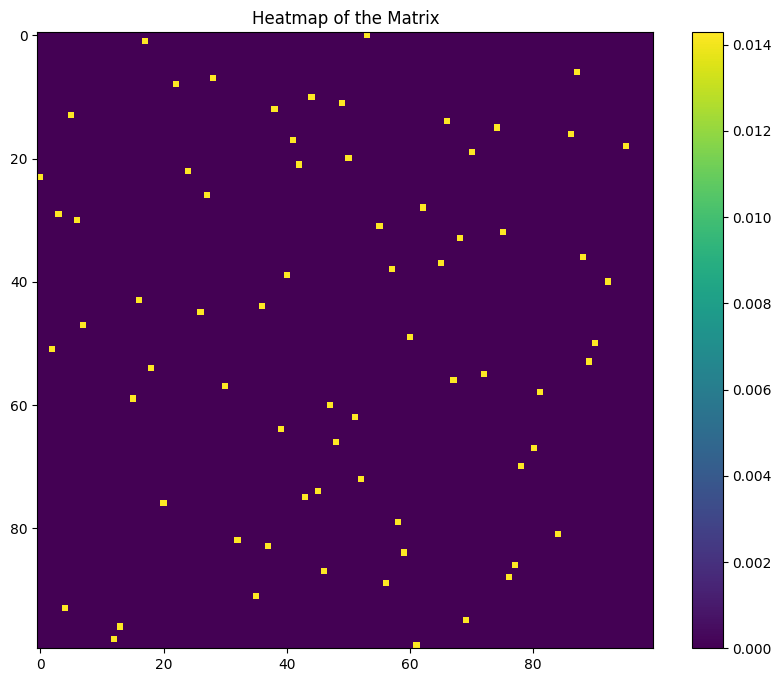

In [114]:
import numpy as np
import matplotlib.pyplot as plt

# Sample matrix for demonstration
matrix = explainer.wd.nu.detach().numpy()

plt.figure(figsize=(10, 8))
plt.imshow(matrix, cmap='viridis')
plt.colorbar()
plt.title("Heatmap of the Matrix")
plt.show()


In [115]:
col_names = []
col_scores = []
for column, col_index in zip(explainer.explain_columns, explainer.explain_indices):

    y_s = torch.FloatTensor(explainer.best_X[:, col_index])
    y_t = torch.FloatTensor(explainer.X_prime[:, col_index])
    wd_dist, _ = explainer.wd.distance(y_s, y_t, delta=0.15)

    col_names.append(column)
    col_scores.append(wd_dist.item())

df_score = pd.DataFrame({
    'Feature': col_names,
    'Score': col_scores,
}).sort_values(by='Score', ascending=False)
df_score

,Feature,Score
2,stays_in_weekend_nights,0.755005
1,booking_changes,0.468045
0,lead_time,0.348774
3,stays_in_week_nights,0.250333
4,days_in_waiting_list,0.061414


DEBUG:matplotlib.colorbar:locator: <matplotlib.ticker.AutoLocator object at 0x0000020B5D055F70>


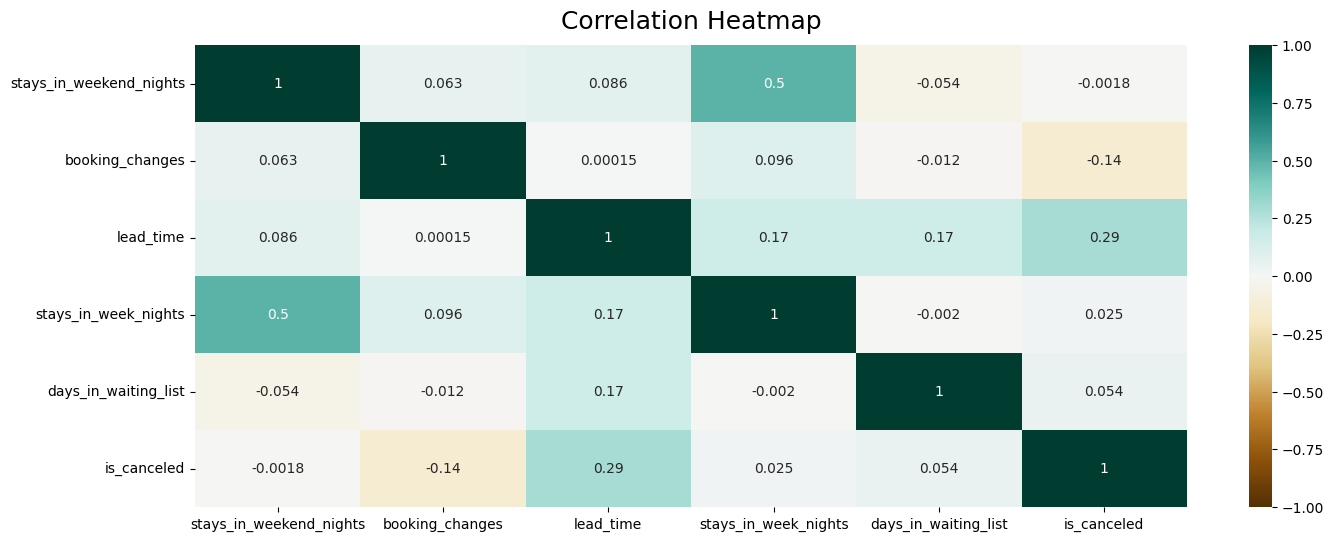

In [116]:
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(df[df_score['Feature'].values.tolist() + ['is_canceled']].corr(), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':18}, pad=12);
# save heatmap as .png file
# dpi - sets the resolution of the saved image in dots/inches
# bbox_inches - when set to 'tight' - does not allow the labels to be cropped
# plt.savefig('heatmap.png', dpi=300, bbox_inches='tight')

In [117]:
fa = torch.zeros_like(explainer.X_prime[:, explainer.explain_indices] @ explainer.swd.thetas[0])
dfa = torch.zeros_like(explainer.X_prime[:, explainer.explain_indices] @ explainer.swd.thetas[0])
for theta in explainer.swd.thetas:

    fa += explainer.X_prime[:, explainer.explain_indices] @ theta
    dfa += explainer.best_X[:, explainer.explain_indices] @ theta
    
fa /= len(explainer.swd.thetas)
dfa /= len(explainer.swd.thetas)

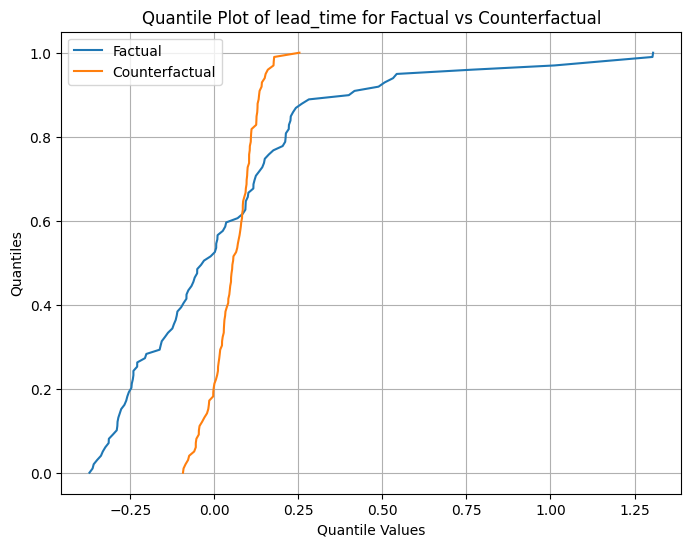

In [118]:
plot_quantile(factual=pd.DataFrame({'X': fa}), counterfactual=pd.DataFrame({'X': dfa}), column_name='X')